<a href="https://colab.research.google.com/github/sattwiksuman/AI_for_Trash_Collection/blob/main/Trash_Collection_RL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<center>Efficient Trash Collection using AI</center>
---
####<center>Reinforced Learning Project - Economic Modelling of Energy and Climate Systems</center>
####<center>Data Analytics and Decision Science</center>
####<center>RWTH Aachen Business School</center>
Submitted by:<br>
Priyanka Kundagol<br>
Sattwik Suman Das<br>
Ved Nerlikar



---
#Introduction

---

To be added.

###The Environment
The Diagram below shows the environment in which the Agent would operate.
The squares in gray are the road.
The Agent is expected to collect trash from the location shown in Black boxes.
The trash is actually collected from the adjacent squares marked by a dark border on the road, i.e., squares 3, 17 and 21.

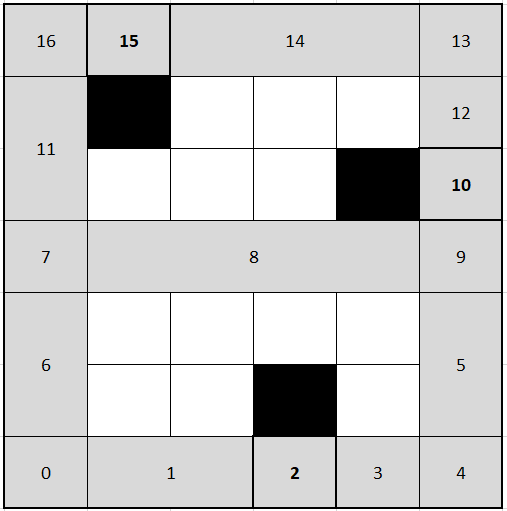

###States of the Environment:
The gray squares above depict the states in which the agent can reside. <br>
So there are 26 states in total numbered 0 to 25. <br>
The movement of the agent from one state to another is defined by defining the rewards of the adjacent states.

###Actions
At each state the agent can 5 actions as follows:
0. Do nothing
1. Move North
2. Move East
3. Move South
4. Move West 

###Action_Space: control the motion
For each state, the next state corresponding to the consequence of the 5 actions will be pre-defined as part of the environment definition. 

###Rewards
The reward of the trash locations 03, 17 and 21 are defined to reflect the amount of trash in the following manner:
1. if trash >= threshold:
        reward= percentage of trash bin full
2. else:
        reward = 0
<br>
The threshold can be set to 70% .

###Reward for road states in form of Living Penalty
A Living Penalty is defined to each of the states on the road because we want the agent to move by taking the shortest time, which would ultimately be the most efficient way to travel. <br>
Living Penalty is not defined to the start location '0' and the trash locations. <br>
The agent is expected to reside at the starting point till it needs to make it's first trip and then reside at the location from which it has collected the trash till it needs to move to the next location to collect from the next location.<br>
Living penalty can be set to -0.2

###Carrying capacity of the Agent
For the initial model, the agent is assumed to have infinite capacity. <br>
This effectively means it never has to return to the depot to empty itself.

###Timestep of the simulation
The timestep can be assumed to be one hour.<br>
In each timestep:
1. the vehicle is assumed to have one state transition.
2. the garbage is updated to new quatities




---
#Importing the packages
---

In [1]:
import gym
from gym import spaces

import numpy as np
from numpy.random import default_rng
from random import random
from random import randint
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam

---
#Building the Environment
---

In [18]:
#Build the environment

class TrashEnv(gym.Env):

    def __init__(self):
        super(TrashEnv, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        n_actions = 5
        #self.action_space = spaces.Discrete(n_actions)

        self.total_states = 17
        self.observation_space = spaces.Discrete(self.total_states)

        #Define the action space:
        self.action_space = {}
        self.action_space[0]={0:0, 1:6, 2:1, 3:0, 4:0}
        self.action_space[1]={0:1, 1:1, 2:2, 3:1, 4:0}
        self.action_space[2]={0:2, 1:2, 2:3, 3:2, 4:1}
        self.action_space[3]={0:3, 1:3, 2:4, 3:3, 4:2}
        self.action_space[4]={0:4, 1:5, 2:4, 3:4, 4:3}
        self.action_space[5]={0:5, 1:9, 2:5, 3:4, 4:5}
        self.action_space[6]={0:6, 1:7, 2:6, 3:0, 4:6}
        self.action_space[7]={0:7, 1:11, 2:8, 3:6, 4:7}
        self.action_space[8]={0:8, 1:8, 2:9, 3:8, 4:7}
        self.action_space[9]={0:9, 1:10, 2:9, 3:5, 4:8}
        self.action_space[10]={0:10, 1:12, 2:10, 3:9, 4:10}
        self.action_space[11]={0:11, 1:16, 2:11, 3:7, 4:11}
        self.action_space[12]={0:12, 1:13, 2:12, 3:10, 4:12}
        self.action_space[13]={0:13, 1:13, 2:13, 3:12, 4:14}
        self.action_space[14]={0:14, 1:14, 2:13, 3:14, 4:15}
        self.action_space[15]={0:15, 1:15, 2:14, 3:15, 4:16}
        self.action_space[16]={0:16, 1:16, 2:15, 3:11, 4:16}
        
        #Define the Garbage locations and corresponding initial garbage quantity values = 0:
        self.garbage_quantity = {}
        self.garbage_locations = [2, 10, 15]
        for l in self.garbage_locations:
            self.garbage_quantity[l]=0.0  

        #Define maximum quatity of garbage that would be updated in one timestep:
        self.max_garbage_update = 0.04   

        #Define threshold after which garbage updation reflects in reward:
        self.garbage_threshold = 0.7
        
        # Set the living penalty
        self.living_penalty_base_value = -0.2
        # living penalty is assigned according to the size of the state: refer to diagram attached above
        self.living_penalty = {0:0,              #reward for initial location must be zero as we allow the agent to reside at 0 before it has to start
                               1:2*self.living_penalty_base_value,
                               2:0,              #reward for garbage location would be assigned later. it is just initialized with 0.
                               3:self.living_penalty_base_value,
                               4:self.living_penalty_base_value,
                               5:2*self.living_penalty_base_value,
                               6:2*self.living_penalty_base_value,
                               7:self.living_penalty_base_value, 
                               8:4*self.living_penalty_base_value,
                               9:self.living_penalty_base_value,
                               10:0,
                               11:2*self.living_penalty_base_value,
                               12:self.living_penalty_base_value,
                               13:self.living_penalty_base_value,
                               14:3*self.living_penalty_base_value,
                               15:0,
                               16:self.living_penalty_base_value
                               }

        
        #Define the Rewards:
        #reward_space is defined as a dictionary of dictionaries {current_state:{action:reward}}
        self.reward_space = {}
        for i in range(len(self.action_space)):
            self.reward_space[i] = self.update_reward(i)
            '''
            dummy_dict={}
            for act, j in zip(self.action_space[i].keys(), self.action_space[i].values()):
                dummy_dict[act]=self.living_penalty[j]
                if j in self.garbage_locations:
                    dummy_dict[act]=self.update_garbage_reward(j)
                if act!=0 and j==i:     #larger penalty for infeasible actions
                    dummy_dict[act]=2*dummy_dict[act]
            self.reward_space[i]=dummy_dict
            '''

        # Create state attribute, initialize it in reset method
        self.state = None

        #Create a variable to measure the distance covered
        #This will be compared against the distance covered in the naive approach
        self.distance_covered = 0

        #Create a variable to store the number of timesteps
        #This can be used to define an epoch
        self.current_time = 0

        #Create a variable to set the status of training to Train or Test or None
        #This allows us not to run the training everytime we run the whole notebook
        self.train = None
        
        
    def step(self, action):
        """State transition of the model.
        Implements the model of the environment.
        Args:
            action (int): Action the agent took.
        Returns:
            next_state (int): The next state the environment emits.
            reward (float): The reward the environment emits.
            done (bool): Currently always set to 0 as we are modelling a continuous process
            garbage_info (dict): Info about the rewards at the garbage locations {loc: reward}
        """
        #assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))
        #assert action <= self.state, "%r is to much extraction, current state: %r" % (action, self.state)

        # Calculate the next state
        next_state = self.action_space[self.state[0]][action]

        # Calculate the reward
        ##Reward can not be set after update of the reward_space following the action
        ##because the reward_space will update the garbage location to zero in case the agent arrives there giving the agent 0 reward.
        #print('printing from ev class', self.reward_space[self.state[0]])
        reward = self.reward_space[self.state[0]][action]

        #Update the garbage_quantity and reward_space:
        if next_state not in self.garbage_locations:    #in free area or stepping out of garbage location
            for l in self.garbage_locations:
                self.garbage_quantity[l]+=random()*self.max_garbage_update
                self.reward_space[l]=self.update_reward(l)
        else:
            if self.state[0] not in self.garbage_locations:    #stepping into garbage location
                for l in self.garbage_locations:
                    if l == next_state:
                        self.garbage_quantity[l]=0.0
                        self.reward_space[l]=self.update_reward(l)
                    else:
                        self.garbage_quantity[l]+=random()*self.max_garbage_update
                        self.reward_space[l]=self.update_reward(l)
            else:       #waiting at a garbage location
                for l in self.garbage_locations:
                    self.garbage_quantity[l]+=random()*self.max_garbage_update
                    self.reward_space[l]=self.update_reward(l)   

        #The episode will be continuous, so there will be no 'Game Over'/ 'Done'
        done = 0

        self.garbage_info = {self.garbage_locations[i]: self.reward_space[l] for i, l in enumerate(self.garbage_locations)}
        
        #If reward of any garbage location is non zero, then living penalty at location 0 is no longer 0
        #Otherwise the agent just learns to stay at the location 0 as it maximizes reward.  
        if all(x==0 for x in [self.reward_space[l][0] for l in self.garbage_locations]):
            self.living_penalty[0]=0
        else:
            self.living_penalty[0]=2*self.living_penalty_base_value
        self.reward_space[0]=self.update_reward(0)

        #Update the distance covered
        if self.state[0] != next_state:
            self.distance_covered += 1 

        #Update the current time
        self.current_time += 1

        #Update the state to the next state:
        self.state = [next_state]
        for l in self.garbage_locations:
            self.state.append(self.garbage_quantity[l])
        #self.state = np.array(self.state)
        return self.state, reward, done, self.garbage_info


    def reset(self):
        """Resets the environment.
        Initializes the state.
        Returns:
            state (int): [state, garbage_quantity at garbage locations]
            garbage_info (dict): Info about the rewards at the garbage locations {loc: reward}
        """
        self.state = [0]
        for l in self.garbage_locations:
            self.garbage_quantity[l]=0.0
            self.state.append(self.garbage_quantity[l])
            self.reward_space[l]=self.update_garbage_reward(l)
        self.distance_covered = 0
        self.current_time = 0
        self.garbage_info = {self.garbage_locations[i]: self.reward_space[l] for i, l in enumerate(self.garbage_locations)}
        #self.state = np.array(self.state)
        return self.state

    #Define update reward function:
    def update_reward(self, location):
        i= location
        dummy_dict={}
        for act, j in zip(self.action_space[i].keys(), self.action_space[i].values()):
            dummy_dict[act]=self.living_penalty[j]
            if j in self.garbage_locations:
                dummy_dict[act]=self.update_garbage_reward(j)
            if act!=0 and j==i:     #larger penalty for infeasible actions
                dummy_dict[act]=2*dummy_dict[act]
                if i in self.garbage_locations:
                    dummy_dict[act]=self.living_penalty_base_value
        return dummy_dict

    def update_garbage_reward(self, garbage_location):
        """Updates the reward space at a garbage location based on the quantity of garbage at the location
        Returns:
            reward_space[garbage_location]
        """
        i=garbage_location
        if i in self.garbage_locations:
                if self.garbage_quantity[i] > 0.7:
                    self.reward_space[i]=self.garbage_quantity[i]
                else:
                    self.reward_space[i]=0.0
        return(self.reward_space[i])

    # We will not implement render and close function
    def render(self, mode='human'):
        pass
    def close (self):
        pass

In [3]:
tr = {1:11, 2:22, 3:33}
for k, v in zip(tr.keys(), tr.values()):
    print(k, v)

1 11
2 22
3 33


In [4]:
len(tr)

3

---
#Testing the environment
---

In [19]:
# Create the environment
test_env = TrashEnv()

# Reset the environment to get initial state
state = test_env.reset()
state = state[0]
print(test_env.garbage_info)

# Create a list to store all states during the simulation
columns=['action', 'state', 'reward']
for key in test_env.garbage_info.keys():
    columns.append(f'reward_at_garbage_{key}')
for key in test_env.garbage_info.keys():
    columns.append(f'garbage_quantity_at_{key}')

row = {'action': 'Initialize', 'state':state, 'reward': 0.0}
for key, val in zip(columns[3:6], test_env.garbage_info.values()):
    row[key]=val
for key, val in zip(columns[6:], test_env.garbage_quantity.values()):
    row[key]=val
print(row)

#Pandas DataFrame test_log stores the state, action, reward and garbage parameters at each timestep. 
test_log = pd.DataFrame(columns=columns)
test_log = test_log.append(row, ignore_index=True)  #the first row is the start position

# Loop over each time step in the episode
done = False
for _ in range(48):
    action = randint(0,4)
    #print('action', action)
    state, reward, _, garbage_info = test_env.step(action)
    state=state[0]
    #print('state', state)
    row = {'action':action, 'state':state, 'reward': reward}
    for key, val in zip(columns[3:], garbage_info.values()):
        row[key]=val
    for key, val in zip(columns[6:], test_env.garbage_quantity.values()):
        row[key]=val
    test_log = test_log.append(row, ignore_index=True)

{2: 0.0, 10: 0.0, 15: 0.0}
{'action': 'Initialize', 'state': 0, 'reward': 0.0, 'reward_at_garbage_2': 0.0, 'reward_at_garbage_10': 0.0, 'reward_at_garbage_15': 0.0, 'garbage_quantity_at_2': 0.0, 'garbage_quantity_at_10': 0.0, 'garbage_quantity_at_15': 0.0}


In [6]:
test_env.state

[2, 0.02524639513058012, 0.9059788957199079, 0.9382403449351284]

In [7]:
test_log

,action,state,reward,reward_at_garbage_2,reward_at_garbage_10,reward_at_garbage_15,garbage_quantity_at_2,garbage_quantity_at_10,garbage_quantity_at_15
0,Initialize,0,0.0,0,0,0,0.000000,0.000000,0.000000
1,1,6,-0.4,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.032546,0.021534,0.012936
2,3,0,0.0,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.067950,0.024930,0.042775
3,3,0,0.0,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.089047,0.045624,0.049134
4,0,0,0.0,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.126516,0.056804,0.054016
5,2,1,-0.4,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.144496,0.084524,0.075886
6,1,1,-0.8,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.175203,0.090236,0.107178
7,3,1,-0.8,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.200109,0.116645,0.124130
8,0,1,-0.4,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.221496,0.131396,0.135787
9,2,2,0.0,"{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.4}","{0: 0.0, 1: -0.2, 2: -0.2, 3: -0.2, 4: -0.2}","{0: 0.0, 1: -0.2, 2: -0.6000000000000001, 3: -...",0.000000,0.146289,0.153196


In [8]:
print(test_env.garbage_locations)
[test_env.reward_space[l][0] for l in test_env.garbage_locations]

[2, 10, 15]


[0.0, 0.9059788957199079, 0.9382403449351284]

In [9]:
tt=[0, 1]
all(x==0 for x in [test_env.reward_space[l][0] for l in test_env.garbage_locations])

False

In [10]:
test_env.reward_space[0]

{0: -0.2, 1: -0.4, 2: -0.4, 3: -0.4, 4: -0.4}

---
#Building the Brain
---

In [11]:
#Build the Brain
'''
BRAIN PARAMETERS (TBD):

Input Layer: Should we just have the current state as the input or the current state
            along with the garbage levels / rewards of the garbage locations as the input
Output layer: output layer will have 5 nodes corresponding to the Q values
            of the 5 possible actions possible for each state
Dense layers: 2 dense layers with 10 nodes each #suggestion
Compiler:
    loss:'mse'
    optimizer: 'Adam'
    learning_rate= 0.001
    #suggestions
'''

# BUILDING THE BRAIN

class Brain(object):
    
    # BUILDING A FULLY CONNECTED NEURAL NETWORK DIRECTLY INSIDE THE INIT METHOD
    
    def __init__(self, learning_rate = 0.001, number_of_state_params = 4, number_actions = 5):
        
        self.learning_rate = learning_rate
        
        # BUILDIND THE INPUT LAYER COMPOSED OF THE INPUT STATE
        states = Input(shape = (number_of_state_params,))
        
        # BUILDING THE FIRST FULLY CONNECTED HIDDEN LAYER WITH DROPOUT ACTIVATED
        x = Dense(units = 64, activation = 'sigmoid')(states)
        x = Dropout(rate = 0.1)(x)
        
        # BUILDING THE SECOND FULLY CONNECTED HIDDEN LAYER WITH DROPOUT ACTIVATED
        y = Dense(units = 32, activation = 'sigmoid')(x)
        y = Dropout(rate = 0.1)(y)
        
        # BUILDING THE OUTPUT LAYER, FULLY CONNECTED TO THE LAST HIDDEN LAYER
        q_values = Dense(units = number_actions, activation = 'softmax')(y)
        
        # ASSEMBLING THE FULL ARCHITECTURE INSIDE A MODEL OBJECT
        self.model = Model(inputs = states, outputs = q_values)
        
        # COMPILING THE MODEL WITH A MEAN-SQUARED ERROR LOSS AND A CHOSEN OPTIMIZER
        self.model.compile(loss = 'mse', optimizer = Adam(lr = learning_rate))


---
#Creating a DQN Object (Agent)
---

In [20]:
#Build the DQN object = Agent
'''
PARAMETERS:

memory: list of length memory_len (we can model this as a queue)
memory_max_len: length of the memory = 50 (approximately 2 days worth of timesteps)
discount: 0.9
'''

class DQN():

    def __init__(self, max_memory = 50, discount = 0.9):
        self.memory = list()
        self.max_memory = max_memory
        self.discount = discount

    '''
    METHODS:

    get_action:
        take the current_state as input and predict the action
        using epsilon delta: random or argmax(predicted Q_values for current_state)
        returns: action
    '''
    def get_action(self, model, current_state, epsilon=0.3):
        
        # PLAYING THE NEXT ACTION BY EXPLORATION
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, number_actions)
        
        # PLAYING THE NEXT ACTION BY INFERENCE
        else:
            q_values = model.predict(np.array(np.matrix(current_state)))   #current_state.shape = (4,)
            action = np.argmax(q_values[0])
        
        return action 

    '''
    update_memory:
        get the transition made in the current timestep and append it to memory
        #transition is defined by [current_state=(state + garbage_info), action, next_state, reward]
        state = [state, garbage_quantity[3], garbage_quantity[7], garbage_quantity[21]]
        if len of memory is == memory_max_len: pop(first element)
    '''

    def update_memory(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    '''
    get_batch:
        batch_size: 10
        input_batch = randomly select min(batch_size, len(memory)) number of states
                    from the memory
        target_batch = for each of the states in the input_batch, 
                    corresponding element of the target_batch will be a list containing
                    the Q values for all the possible actions for that state
                    predicted by the Brain; here we will subsequently have to update
                    the Q_value corresponding to the action played (from the memory)
                    to reward + discount * max(predicted values for next_state)
    '''
    def get_batch(self, model, batch_size = 10):
        len_memory = len(self.memory)
        num_inputs = len(self.memory[0][0])   #fist element of the memory = transition, first element of transition = state, input = state
        num_outputs = model.output_shape[-1]
        #print(num_inputs, num_outputs)
        inputs = np.zeros((min(len_memory, batch_size), num_inputs))
        targets = np.zeros((min(len_memory, batch_size), num_outputs))
        #print(f'inputs: {inputs}, targets: {targets}')
        for i, idx in enumerate(np.random.randint(0, len_memory, size = min(len_memory, batch_size))):
            current_state, action, next_state, reward = self.memory[idx]
            inputs[i] = current_state
            targets[i] = model.predict(np.matrix(current_state))[0]
            #print(f'output targets of the model: {targets[i]}')
            Q_sa = np.max(model.predict(np.matrix(next_state))[0])
            targets[i, action] = reward + self.discount * Q_sa
            #print(f'target after Q update: {targets[i]}')
        return inputs, targets



---
#Training
---



In [21]:
#Train the Model and save it
'''
Create an object of Environment, Brain and DQN Agent
create a model of brain class
Number_epochs: number of epochs
For each epoch:
    current_state = environment.reset()
    action = DQN.get_action(current_state)
    next_state, reward, _, _ = environment.step(action)
    update the memory: DQN.update_memory(transition=[current_state, action, next_state, reward])
    get the batches of input and output:
    batch_input, batch_target = DQN.get_batch()
    train on the batch and update the loss:
    loss += model.train_on_batch(batch_input, batch_target)
    update the total reward
    keep a track of the timestep
    each epoch can be decided to run for a certain number of timesteps
print the results of the training
save the model for testing/ simulation    
'''

#Set the parameters:
epsilon = 0.3   #for epsilon delta exploration
number_actions = 5
number_epochs = 2
max_memory = 5
discount = 0.9
batch_size = 4

'''
Set environment parameters and include arguments in the environment class in case
parameters of the environment such as:
    item{garbage_update
    garbage_threshold
    living_penalty
need to be tuned in the environment object.
'''

#Create the environment as an object of environmemt class
env = TrashEnv()

#Create the Deep Neural Network as an object of the Brain class
brain = Brain()
model = brain.model
print(model.summary())

#Create the Agent as an object of the DQN class
dqn = DQN(max_memory, discount)

#Set mode to training:
env.train = 'Train'

#Start the training
if env.train == 'Train':
    for epoch in range(number_epochs):
        total_reward = 0.0
        loss = 0.0
        timestep=0
        current_state = env.reset()
        print(f'Epoch: {epoch+1}/{number_epochs}')
        for _ in tqdm(range(500)):
            #print('\n')
            action = dqn.get_action(model=model, current_state=current_state, epsilon=epsilon)
            next_state, reward, _, _ = env.step(action)
            transition=[current_state, action, next_state, reward]
            #print(f'transition: {transition}')
            dqn.update_memory(transition)
            batch_input, batch_target = dqn.get_batch(model, batch_size = batch_size)
            loss += model.train_on_batch(batch_input, batch_target)
            total_reward +=reward
            current_state = next_state
        #Print the results for the current epoch
        print(f'Total loss over the epoch: {loss}')
        print(f'Total reward over the epoch: {total_reward}')
        print("\n")
        # EARLY STOPPING CAN BE IMPLEMENTED LATER
        
        # SAVING THE MODEL
        model.save("model.h5")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 165       
Total params: 2,565
Trainable params: 2,565
Non-trainable params: 0
_________________________________________________________


Total loss over the epoch: 19.430330315575702
Total reward over the epoch: -157.20000000000047


Epoch: 2/2



Total loss over the epoch: 26.103402068139985
Total reward over the epoch: -191.40000000000023






---
#Testing

---




In [14]:
#Test the model on a similar environment and publish the results
'''
build a simulation environment
load the saved model
current_state=environment.reset()
run simulation for timestep < some value:
    q_values = model.predict(current_state)
    action = np.argmax(q_values)
    next_state, reward, _, _ = environment.step(action)
    current_state = next_state
    update reward
    #maintain a counter for each time the trash in a particular bin 70%:
        if abs(reward[3] at current timestep - reward[3] at last timestep) 
'''
from keras.models import load_model

#Create simulation environment
sim_env = TrashEnv()

#Load the pre-trained model
trained_model = load_model('model.h5')

#Running a 5 day training:

total_reward = 0.0
loss = 0.0
timestep=0
current_state = sim_env.reset()
while timestep <= 50:
    #print('\n')
    #print(timestep)
    q_values = trained_model.predict(np.array(np.matrix(current_state)))
    #print(q_values)
    action = np.argmax(q_values[0])
    next_state, reward, _, _ = sim_env.step(action)
    transition=[current_state, action, next_state, reward]
    print(f'transition: {transition}')
    total_reward +=reward
    current_state = next_state
    timestep +=1
#Print the results for the current epoch
print("\n")
print(f'Total reward: {total_reward}')


transition: [[0, 0.0, 0.0, 0.0], 0, [0, 0.03880479638630151, 0.02361615845608982, 0.03883268106481518], 0]
transition: [[0, 0.03880479638630151, 0.02361615845608982, 0.03883268106481518], 0, [0, 0.0672915131302999, 0.06193417479179829, 0.04909165291915501], 0]
transition: [[0, 0.0672915131302999, 0.06193417479179829, 0.04909165291915501], 0, [0, 0.10127623151954408, 0.10186985796539486, 0.08880190180468374], 0]
transition: [[0, 0.10127623151954408, 0.10186985796539486, 0.08880190180468374], 0, [0, 0.11543981420344974, 0.13702018022702508, 0.09760448315398171], 0]
transition: [[0, 0.11543981420344974, 0.13702018022702508, 0.09760448315398171], 0, [0, 0.14694364506261895, 0.14463706923194244, 0.11644923567417553], 0]
transition: [[0, 0.14694364506261895, 0.14463706923194244, 0.11644923567417553], 0, [0, 0.1837281048255447, 0.15890374112667888, 0.1309173164476584], 0]
transition: [[0, 0.1837281048255447, 0.15890374112667888, 0.1309173164476584], 0, [0, 0.1905726790391333, 0.19159590928330

In [15]:
np.argmax(q_values[0])

0



---
#Printing and Visualizing the Results

---






In [16]:
#Print the results
#Report the observations
#Create a visualization
#Write a Conclusion

In [17]:
#Animation of the results

#convert results in desired format (TBD)
results = []
'''
#Making the grid
N = 6
M = 7
Roads = np.ones((N, M)) * np.nan    #Empty set
fig, ax = plt.subplots(1, 1, tight_layout=True)  #fig + axes
Roads_cmap = matplotlib.colors.ListedColormap(['Grey']) #grey for borders
for x in range(N + 1):      #draw grid
    for y in range(M+1):
        ax.axhline(x, lw=2, color='k', zorder=5)
        ax.axvline(x, lw=2, color='k', zorder=5)
ax.imshow(Roads, interpolation='none', cmap=Roads_cmap, extent=[0, N, 0, M], zorder=0)   #roads
ax.axis('off')   #remove axis

#Highlighting pre-defined cells (Roads & pickups)

#Creating animation
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()
'''

"\n#Making the grid\nN = 6\nM = 7\nRoads = np.ones((N, M)) * np.nan    #Empty set\nfig, ax = plt.subplots(1, 1, tight_layout=True)  #fig + axes\nRoads_cmap = matplotlib.colors.ListedColormap(['Grey']) #grey for borders\nfor x in range(N + 1):      #draw grid\n    for y in range(M+1):\n        ax.axhline(x, lw=2, color='k', zorder=5)\n        ax.axvline(x, lw=2, color='k', zorder=5)\nax.imshow(Roads, interpolation='none', cmap=Roads_cmap, extent=[0, N, 0, M], zorder=0)   #roads\nax.axis('off')   #remove axis\n\n#Highlighting pre-defined cells (Roads & pickups)\n\n#Creating animation\nfrom matplotlib.animation import FuncAnimation\n\nfig, ax = plt.subplots()\nxdata, ydata = [], []\nln, = plt.plot([], [], 'ro')\n\ndef init():\n    ax.set_xlim(0, 2*np.pi)\n    ax.set_ylim(-1, 1)\n    return ln,\n\ndef update(frame):\n    xdata.append(frame)\n    ydata.append(np.sin(frame))\n    ln.set_data(xdata, ydata)\n    return ln,\n\nani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128)